# DAStool tutorial
## Introduction to some DAS tools 
The following is inspired from: 
- [Ethan Williams' Jupyter Notebook](https://gist.github.com/ethanfwilliams/c7c952220ac329db48f8ef159f0b169f)
- [The DAS4Whales package](https://github.com/leabouffaut/DAS4Whales)
___
### Import

In [2]:
import h5py
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
from datetime import datetime
from dastools import dasfuncs, dasplots

Download a file from the OOI dataset

In [3]:
# File from DAS4Whales tutorial
url = 'http://piweb.ooirsn.uw.edu/das/data/Optasense/NorthCable/TransmitFiber/' \
        'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-03T15_06_51-0700/'\
        'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T020002Z.h5'

# File from Ethan's tutorial
# url = 'http://piweb.ooirsn.uw.edu/das/data/Optasense/NorthCable/TransmitFiber/' \
#         'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-03T15_06_51-0700/'\
#         'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T022302Z.h5'

filepath = dasfuncs.dl_file(url)

North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T020002Z.h5 already stored locally


Read the HDF5 files and print the metadata keys

In [4]:
# Open the file for reading
fp = h5py.File(filepath,'r')
metadata = dasfuncs.get_metadata_optasense(fp)

# Print the keys for the top-level object in the file
print(f'Sampling frequency: {metadata["fs"]} Hz')
print(f'Gauge length: {metadata["GL"]} m')
print(f'File duration: {metadata["ns"]/metadata["fs"]} s')
print(f'Channel spacing: {metadata["dx"]} m')
print(f'Number of channels: {metadata["nx"]}')
print(f'Number of time samples: {metadata["ns"]}')


Sampling frequency: 200.0 Hz
Gauge length: 51.0476188659668 m
File duration: 60.0 s
Channel spacing: 2.0419046878814697 m
Number of channels: 32600
Number of time samples: 12000


Plot the traces for some channels

[]

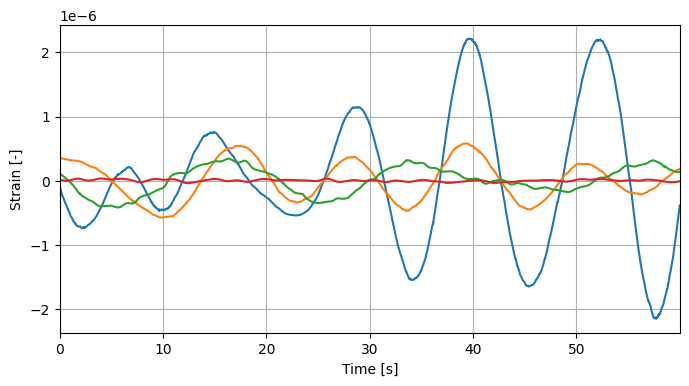

In [5]:
h5array = fp['Acquisition']['Raw[0]']['RawData']
dasplots.plot_trace(h5array, metadata)
plt.plot()

Plot the power spectral density for some channels

[]

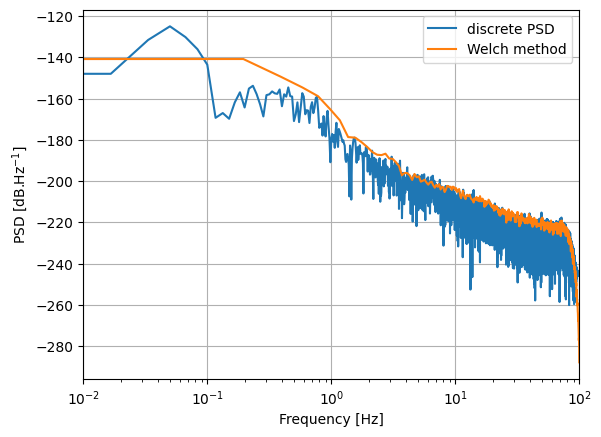

In [6]:
dasplots.plot_psd(h5array, metadata, channels=[15000,])
plt.plot()

Plot the waterfall

In [7]:
# Select a portion of the cable between the indexes xmin and xmax
xmin = int(15000 / metadata['dx'])  
xmax = int(40000 / metadata['dx'])
# Scale the data to get strain values
sarray = dasfuncs.scale(h5array[xmin:xmax,:], metadata)
dist = np.linspace(xmin * metadata['dx'], xmax * metadata['dx'])
times = np.linspace(0, metadata['ns']/metadata['fs'])

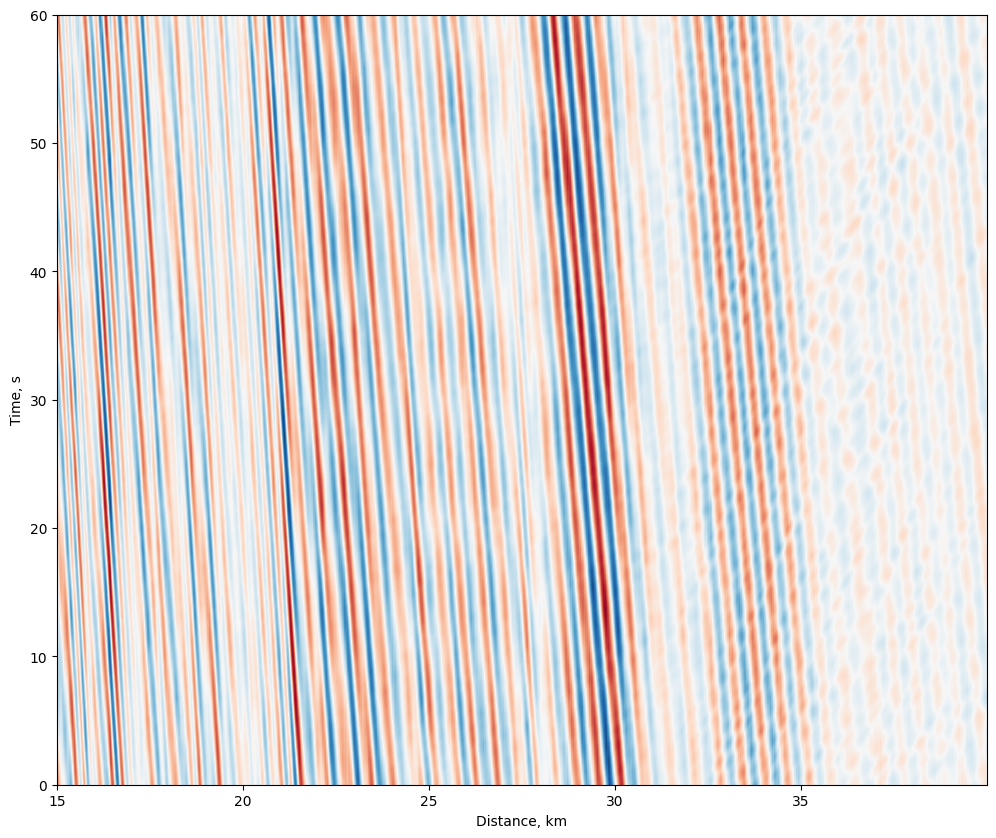

In [8]:
dasplots.plot_waterfall(sarray, dist, times, sarray.min(), sarray.max(), dist.min(), dist.max(),1)

Filter between 15 Hz and 25 Hz

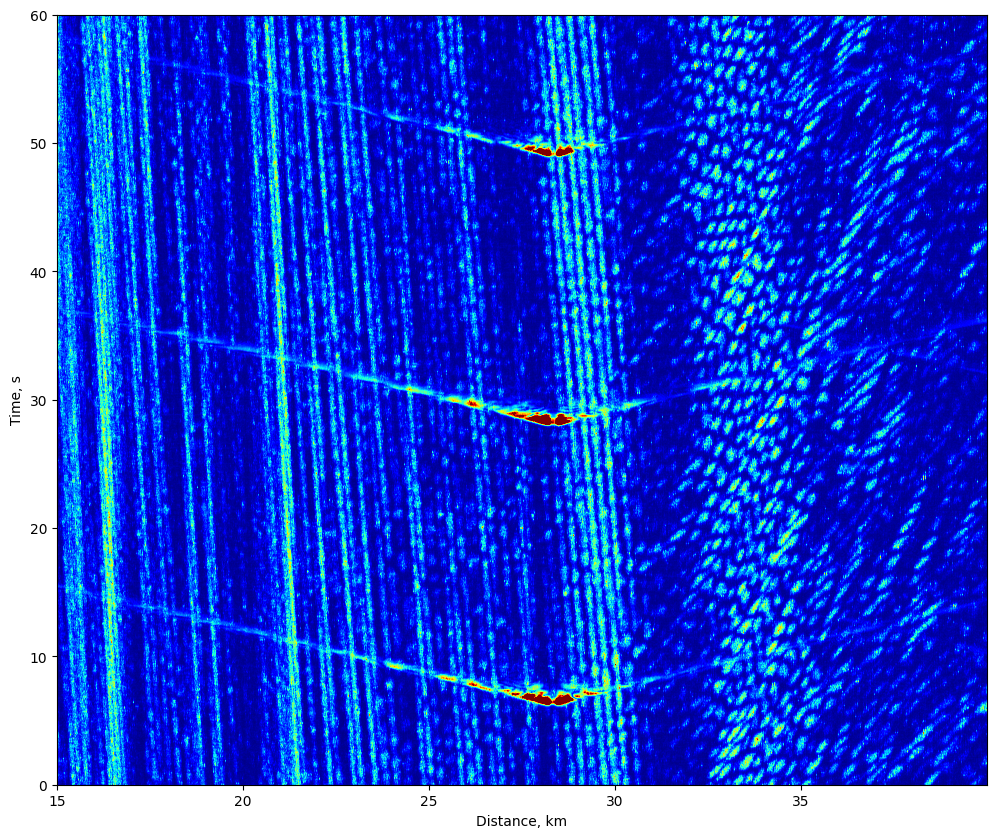

In [9]:
# Apply a band-pass filter: 
fsarray = dasfuncs.bp_filt(sarray, metadata['fs'], 15, 25)
# Compute the envelope:
en = abs(sp.hilbert(fsarray,axis=1))
# Plot the waterfall
dasplots.plot_waterfall(en, dist, times, 0, en.max()*0.1, dist.min(), dist.max(),1, cmap='jet')

Apply f-k filtering to isolate acoustic waves (that satisfies the dispersion relation $\omega = kc_\text{water}$)

In [11]:
# Reduce the time scale to see 
tmin = int(0*metadata['fs'])
tmax = int(40*metadata['fs']) 
rtimes = np.linspace(tmin, tmax)/metadata['fs']
acarray = dasfuncs.fk_filt(fsarray[:,tmin:tmax], 1, metadata['fs'], 1, metadata['dx'], 1400, 3500)

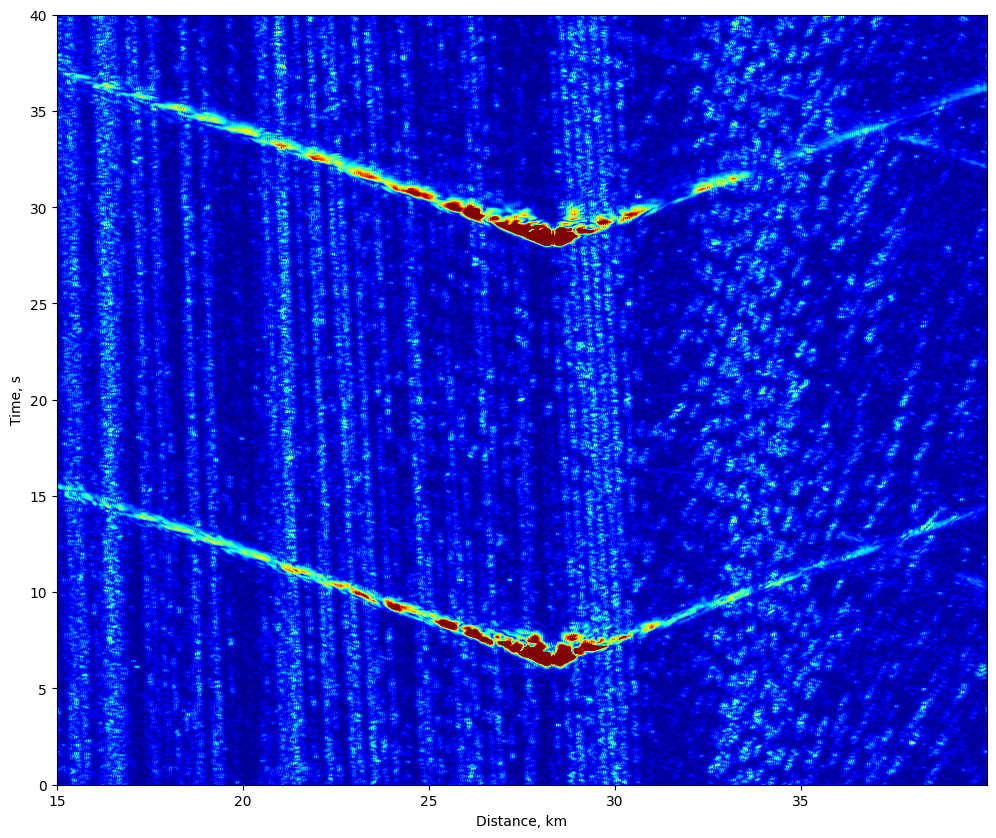

In [12]:
# Compute the envelope:
ac_en = abs(sp.hilbert(acarray[:,:],axis=1))
# Plot the waterfall
dasplots.plot_waterfall(ac_en, dist, rtimes, 0, ac_en.max()*0.1, dist.min(), dist.max(),1, cmap='jet')